In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

import gym
import random
import numpy as np
from collections import deque


from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.autograd import Variable
from scipy.spatial.distance import pdist, squareform, cdist


In [56]:
def mini_batch_train(env, agent, max_episodes, max_steps, batch_size):
    episode_rewards = []
    update_step = 0

    for episode in range(max_episodes):
        #print("episode=",episode,"max_episodes=",max_episodes)
        state = env.reset()
        episode_reward = 0
        
        for step in range(max_steps):
#             if step==3:
#                 print("step=",step, "state=",state)
            action = agent.get_action(state)
            
            next_state, reward, done, _ = env.step(action)
            agent.replay_buffer.push(state, action, reward, next_state, done)
            episode_reward += reward

            if len(agent.replay_buffer) > batch_size:
                agent.update(batch_size)
                update_step += 1
#             print("step=",step,"max_steps-1=",max_steps-1)
            if done or step == max_steps-1:
#                 print("step=",step)
                episode_rewards.append(episode_reward)                
                break

            state = next_state
            #print("step=",step,"next state=",state,"episode_reward=",episode_reward)
        
        #print("done....")
        print("Episode " + str(episode) + ": " + str(episode_reward))

    return episode_rewards

In [57]:
class BasicBuffer:

  def __init__(self, max_size):
      self.max_size = max_size
      self.buffer = deque(maxlen=max_size)

  def push(self, state, action, reward, next_state, done):
      experience = (state, action, np.array([reward]), next_state, done)
      self.buffer.append(experience)

  def sample(self, batch_size):
      state_batch = []
      action_batch = []
      reward_batch = []
      next_state_batch = []
      done_batch = []

      batch = random.sample(self.buffer, batch_size)

      for experience in batch:
          state, action, reward, next_state, done = experience
          state_batch.append(state)
          action_batch.append(action)
          reward_batch.append(reward)
          next_state_batch.append(next_state)
          done_batch.append(done)

      return (state_batch, action_batch, reward_batch, next_state_batch, done_batch)

  def __len__(self):
      return len(self.buffer)

In [58]:
class ValueNetwork(nn.Module):

    def __init__(self, input_dim, output_dim, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, output_dim)

        self.fc3.weight.data.uniform_(-init_w, init_w)
        self.fc3.bias.data.uniform_(-init_w, init_w)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


class SoftQNetwork(nn.Module):
    
    def __init__(self, num_inputs, num_actions, hidden_size=256, init_w=3e-3):
        super(SoftQNetwork, self).__init__()
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)

        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x



In [59]:
class PolicyNetwork(nn.Module):
    
    def __init__(self, num_inputs, num_actions, hidden_size=256, init_w=3e-3, 
                 log_std_min=-20, log_std_max=2, sinkhorn_iters=5, sinkhorn_tau=1):
        
        super(PolicyNetwork, self).__init__()
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)

        self.mean_linear = nn.Linear(hidden_size, num_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)

        self.log_std_linear = nn.Linear(hidden_size, num_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)

    def forward(self, state):
#         print("forward state=",state)
#         print("self.linear1(state)=",self.linear1(state))
        x = F.relu(self.linear1(state.squeeze()))
        
        x = F.relu(self.linear2(x))

        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
      
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        


        return mean, log_std

    def sample(self, state, epsilon=1e-6):
        mean, log_std= self.forward(state)
        std = log_std.exp()

        normal = Normal(mean, std)
        z = normal.rsample()
        action = torch.tanh(z)

        log_pi = normal.log_prob(z) - torch.log(1 - action.pow(2) + epsilon)
        log_pi = log_pi.sum(1, keepdim=True)

        return action, log_pi
     

In [78]:
class SACAgent:
  
    def __init__(self, env, gamma, tau, v_lr, q_lr, policy_lr, buffer_maxlen, M = 20,a0 = 1, b0 = 0.1):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.env = env        
        self.action_range = [env.action_space.low, env.action_space.high]

        # hyperparameters
        self.gamma = gamma
        self.tau = tau       
        self.update_step = 0
        self.delay_step = 2

        # initialize networks 
        self.value_net = ValueNetwork(env.observation_space.shape[0], 1).to(self.device)
        self.target_value_net = ValueNetwork(env.observation_space.shape[0], 1).to(self.device)
        self.q_net1 = SoftQNetwork(env.observation_space.shape[0], env.action_space.shape[0]).to(self.device)
        self.q_net2 = SoftQNetwork(env.observation_space.shape[0], env.action_space.shape[0]).to(self.device)
        self.policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.shape[0]).to(self.device)
        print("state.space=",env.observation_space.shape[0],"action.space=",env.action_space.shape[0])
        
        # copy params to target param
        for target_param, param in zip(self.target_value_net.parameters(), self.value_net.parameters()):
            target_param.data.copy_(param)
            
        # initialize optimizers 
        self.value_optimizer = optim.Adam(self.value_net.parameters(), lr=v_lr)
        self.q1_optimizer = optim.Adam(self.q_net1.parameters(), lr=q_lr)
        self.q2_optimizer = optim.Adam(self.q_net2.parameters(), lr=q_lr)
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=policy_lr)

        self.replay_buffer = BasicBuffer(buffer_maxlen)
        
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        
        mean, log_std = self.policy_net.forward(state)
        
        std = log_std.exp()
        
        normal = Normal(mean, std)
        z = normal.sample()
        action = torch.tanh(z)
        action = action.cpu().detach().squeeze(0).numpy()
        
        return self.rescale_action(action)
    
    def rescale_action(self, action):
        return action * (self.action_range[1] - self.action_range[0]) / 2.0 +\
            (self.action_range[1] + self.action_range[0]) / 2.0
   
    def update(self, batch_size):
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.FloatTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        dones = dones.view(dones.size(0), -1)
        
        next_actions, next_log_pi = self.policy_net.sample(next_states)
        next_q1 = self.q_net1(next_states, next_actions)
        next_q2 = self.q_net2(next_states, next_actions)
        next_v = self.target_value_net(next_states)
        
        # value Loss
        next_v_target = torch.min(next_q1, next_q2) - next_log_pi
        curr_v = self.value_net.forward(states)
        v_loss = F.mse_loss(curr_v, next_v_target.detach())
        
        # q loss
        curr_q1 = self.q_net1.forward(states, actions)
        curr_q2 = self.q_net2.forward(states, actions)
        expected_q = rewards + (1 - dones) * self.gamma * next_v
        q1_loss = F.mse_loss(curr_q1, expected_q.detach())
        q2_loss = F.mse_loss(curr_q2, expected_q.detach())
        
        # update value network and q networks
        self.value_optimizer.zero_grad()
        v_loss.backward()
        self.value_optimizer.step()
        
        self.q1_optimizer.zero_grad()
        q1_loss.backward()
        self.q1_optimizer.step()
        
        self.q2_optimizer.zero_grad()
        q2_loss.backward()
        self.q2_optimizer.step()
        
        #delayed update for policy net and target value nets
        if self.update_step % self.delay_step == 0:
            new_actions, log_pi = self.policy_net.sample(states)

            min_q = torch.min(
                self.q_net1.forward(states, new_actions),
                self.q_net2.forward(states, new_actions)
            )
            policy_loss = (log_pi - min_q).mean()
            #policy_loss.backward()
            #print("policy_loss=",policy_loss)
            dg = dgf_nn(env.action_space.shape[0],self.policy_net,states,20, 1,0.1)
            updated_theta = dg.train( states,self.policy_net,self.policy_optimizer,policy_loss,min_q,batch_size, 1000, 20,50, 1, 0.1,1e-3, 0.9)
            flat_grad = updated_theta.mean(axis=0).reshape(-1,1)
            #print("flat_grad.shape=",flat_grad.shape)
            prev_ind=0
            for param in self.policy_net.parameters():
                flat_size = int(np.prod(list(param.size())))
                param.grad.copy_(torch.from_numpy(flat_grad[prev_ind:prev_ind + flat_size]).view(param.size()))                
                prev_ind += flat_size
                
            self.policy_optimizer.step()

            for target_param, param in zip(self.target_value_net.parameters(), self.value_net.parameters()):
                target_param.data.copy_(self.tau * param + (1 - self.tau) * target_param)

        self.update_step += 1

In [81]:
env = gym.make("Pendulum-v0")

# SAC 2018 Params
tau = 0.005
gamma = 0.99
value_lr = 3e-3
q_lr = 3e-3
policy_lr = 3e-3
buffer_maxlen = 1000000

# 2018 agent
agent = SACAgent(env, gamma, tau, value_lr, q_lr, policy_lr, buffer_maxlen)

# train
episode_rewards = mini_batch_train(env, agent, 100, 3, 2)
#env, agent, max_episodes, max_steps, batch_size):

state.space= 3 action.space= 1
Episode 0: -22.742541665748796
Episode 1: -5.961093395985188
Episode 2: -5.050307702200119
Episode 3: -3.708320883316463
Episode 4: -3.4260098802214687
Episode 5: -1.3688983418895528
Episode 6: -1.685768489283554
Episode 7: -20.10598641444002
Episode 8: -8.581352878394773
Episode 9: -9.387479372293267
Episode 10: -8.973697565101874
Episode 11: -23.035481085343584
Episode 12: -12.932212941456564
Episode 13: -1.5112801259703192
Episode 14: -0.6605058359632344
Episode 15: -22.55724701242325
Episode 16: -12.230896916862498
Episode 17: -3.7260162035798983
Episode 18: -7.708381252850584
Episode 19: -24.116313832200376
Episode 20: -17.44885910711335
Episode 21: -4.254276909967154
Episode 22: -11.183878000274213
Episode 23: -5.9561774724272505
Episode 24: -1.89573713025385
Episode 25: -5.5703895987219845
Episode 26: -19.151557790293605
Episode 27: -3.171663336878213
Episode 28: -16.25459923425773
Episode 29: -21.137661228159935
Episode 30: -1.4549361488650088
Epi

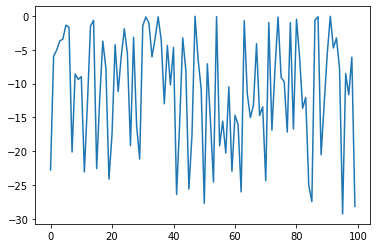

In [82]:
import matplotlib.pyplot as plt
plt.plot(episode_rewards)

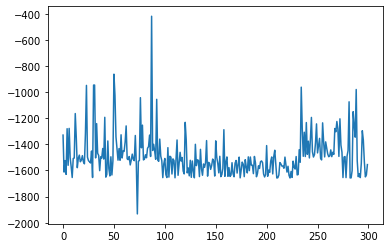

In [66]:
import matplotlib.pyplot as plt
plt.plot(episode_rewards)

In [75]:
class dgf_nn:

    '''
        We define a one-hidden-layer-neural-network specifically. We leave extension of deep neural network as our future work.
        
        Input
            -- M: number of particles are used to fit the posterior distribution
            -- n_hidden: number of hidden units
            -- a0, b0: hyper-parameters of Gamma distribution
            -- master_stepsize, auto_corr: parameters of adgrad
    '''
    def __init__(self, num_actions, poly_model,X,M = 20, n_hidden = 50, a0 = 1, b0 = 0.1):
#         self.n_hidden = n_hidden
#         self.d = context_dim # number of data, dimension
        self.num_class = num_actions # number of actions
        self.M = M # number of particles
        
        
        self.num_vars = len(torch.nn.utils.parameters_to_vector(poly_model.parameters())) 
        #print("len(num_vars)=",self.num_vars)
        self.theta = np.zeros([self.M, self.num_vars])  # particles, will be initialized later
        self.oldtheta = np.zeros([self.M, self.num_vars])  # particles, will be initialized later
        for i in range(self.M):  
            param_vector = torch.nn.utils.parameters_to_vector(poly_model.parameters())
            n_params = len(param_vector)
            noise = Normal(0, 1).sample_n(n_params)
            param_vector.add_(noise)
            torch.nn.utils.vector_to_parameters(param_vector, poly_model.parameters())
            self.theta[i,:] = torch.nn.utils.parameters_to_vector(poly_model.parameters()).detach().squeeze(0).numpy()
            self.oldtheta[i, :] = self.theta[i,:]
#         print("init self.theta=",self.theta)
#         print('Successfully initialized the models!')
        
    
    def train(self, X_train,policy_net,policy_optimizer,policy_loss,min_q, batch_size = 512, max_iter = 1000, M = 20, n_hidden = 50, a0 = 1, b0 = 0.1, master_stepsize = 1e-3, auto_corr = 0.9):
        N0 = X_train.shape[0]  # number of observations
        
        grad_theta = np.zeros([self.M, self.num_vars])  # gradient 
        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad = 0
        iter = 0
        batch = [ i % N0 for i in range(iter * batch_size, (iter + 1) * batch_size) ]
        
        for i in range(self.M):
            new_actions, log_pi = policy_net.sample(X_train)
#             print("new_actions=",new_actions.shape)
            loss = (log_pi - min_q).mean()
            policy_net.zero_grad()
            loss.backward(retain_graph=True)
#             loss.backward()
            grads = []
            for param in policy_net.parameters():
                grads.append(param.grad.view(-1))
            grads = torch.cat(grads)
            grad_theta[i,:] = np.array(grads)
        #print("grad_theta=",grad_theta) 
        
        # calculating the kernel matrix
        if(self.M > 1):
            w2_kxy, w2_dxkxy = self.w2_kernel(h=-1)
            w2_dxkxy=0
            kxy, dxkxy = self.svgd_kernel(h=-1)
            
            grad_theta = (np.matmul(kxy, grad_theta) + 0.5 * w2_dxkxy) / self.M   # \Phi(x)
            
       ########### Stop Here ###############

        self.oldtheta = np.copy(self.theta)

        # adagrad 
        if iter == 0:
            historical_grad = historical_grad + np.multiply(grad_theta, grad_theta)
        else:
            historical_grad = auto_corr * historical_grad + (1 - auto_corr) * np.multiply(grad_theta, grad_theta)
        adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
        self.theta = self.theta + master_stepsize * adj_grad 
        
        return self.theta 
        
        '''
        Calculate kernel matrix and its gradient: K, \nabla_x k
    ''' 
    def svgd_kernel(self, h = -1):
        sq_dist = pdist(self.theta)
#         print("after self.theta=",self.theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = np.sqrt(0.5 * h / np.log(self.theta.shape[0]+1))

        # compute the rbf kernel
        
        Kxy = np.exp( -pairwise_dists / h**2 / 2)
        

        dxkxy = -np.matmul(Kxy, self.theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(self.theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(self.theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy)
    
    def w2_kernel(self, h = -1):
        pairwise_dists = cdist(self.theta, self.oldtheta)**2
        
        # pdb.set_trace()
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = np.sqrt(0.5 * h / np.log(self.theta.shape[0]+1))

        # compute the rbf kernel
        
        Kxy = np.exp(-pairwise_dists / h**2 / 2) * (1-pairwise_dists / (h ** 2))

        dxkxy = -np.matmul(Kxy, self.oldtheta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(self.theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(self.theta[:,i], sumkxy)
        dxkxy = dxkxy
        
        return (Kxy, dxkxy)
    

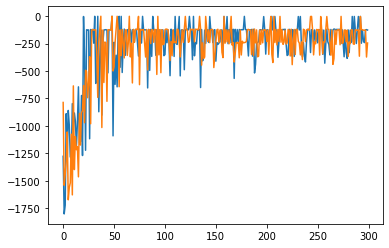

In [92]:
import matplotlib.pyplot as plt
plt.plot(episode_rewards)
plt.plot(reward_2)

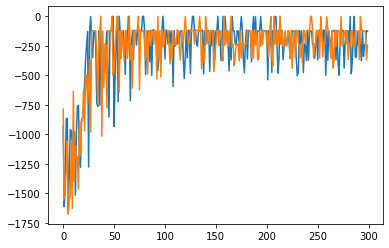

In [79]:
import matplotlib.pyplot as plt
plt.plot(episode_rewards)
plt.plot(reward_2)

In [68]:
reward_1 = episode_rewards

In [72]:
reward_2 = episode_rewards

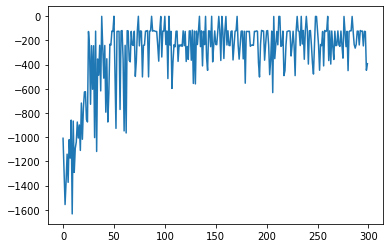

In [74]:
import matplotlib.pyplot as plt
plt.plot(reward_1)

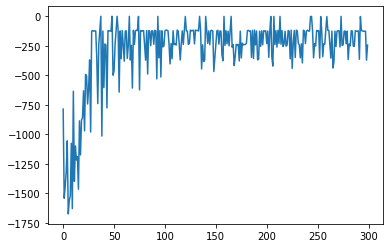

In [75]:
import matplotlib.pyplot as plt
plt.plot(reward_2)

In [ ]:
class dgf_nn:

    '''
        We define a one-hidden-layer-neural-network specifically. We leave extension of deep neural network as our future work.
        
        Input
            -- M: number of particles are used to fit the posterior distribution
            -- n_hidden: number of hidden units
            -- a0, b0: hyper-parameters of Gamma distribution
            -- master_stepsize, auto_corr: parameters of adgrad
    '''
    def __init__(self, context_dim, num_actions, M = 20, n_hidden = 50, a0 = 1, b0 = 0.1):
        self.n_hidden = n_hidden
        self.d = context_dim # number of data, dimension
        self.num_class = num_actions # number of actions
        self.M = M # number of particles
        
        
        self.num_vars = self.d * n_hidden + n_hidden * (1 + self.num_class) + self.num_class + 2  # w1: d*n_hidden; b1: n_hidden; w2 = n_hidden*num_class; b2 = num_class; 2 variances
        self.theta = np.zeros([self.M, self.num_vars])  # particles, will be initialized later
        self.oldtheta = np.zeros([self.M, self.num_vars])  # particles, will be initialized later
        '''
            Theano symbolic variables
            Define the neural network here
        '''
        X = T.matrix('X') # Feature matrix
        y = T.matrix('y') # labels
        mask = T.matrix('mask') # labels
        
        w_1 = T.matrix('w_1') # weights between input layer and hidden layer
        b_1 = T.vector('b_1') # bias vector of hidden layer
        w_2 = T.matrix('w_2') # weights between hidden layer and output layer
        b_2 = T.vector('b_2') # bias of output
        
        N = T.scalar('N') # number of observations
        
        log_gamma = T.scalar('log_gamma')   # variances related parameters
        log_lambda = T.scalar('log_lambda')
        
        ###
        # prediction = T.nnet.nnet.softmax(T.dot(T.nnet.relu(T.dot(X, w_1)+b_1), w_2) + b_2)
        prediction = T.dot(T.nnet.relu(T.dot(X, w_1)+b_1), w_2) + b_2
        
        ''' define the log posterior distribution '''
        # log_lik_data = T.sum(T.sum(y * mask * T.log(prediction))) + 1e-3 * log_gamma

        log_lik_data = - T.sum(T.power(prediction - y, 2) * mask) + 1e-3 * log_gamma

        # log_prior_w = -0.5 * (self.num_vars-2) * (T.log(2*np.pi)-log_lambda) - (T.exp(log_lambda)/2)*((w_1**2).sum() + (w_2**2).sum() + (b_1**2).sum() + (b_2**2).sum())  \
        #                + (a0-1) * log_lambda - b0 * T.exp(log_lambda) + log_lambda
        
        priorprec = T.log(b0/a0)
        log_prior_w = -0.5 * (self.num_vars-2) * (T.log(2*np.pi)-priorprec) - (T.exp(priorprec)/2)*((w_1**2).sum() + (w_2**2).sum() + (b_1**2).sum() + (b_2**2).sum())  \
                        + 1e-3* log_lambda

        # sub-sampling mini-batches of data, where (X, y) is the batch data, and N is the number of whole observations
        log_posterior = (log_lik_data * N / X.shape[0] + log_prior_w)
        dw_1, db_1, dw_2, db_2, d_log_gamma, d_log_lambda = T.grad(log_posterior, [w_1, b_1, w_2, b_2, log_gamma, log_lambda])
        
        # automatic gradient
        self.logp_gradient = theano.function(
             inputs = [X, y, mask, w_1, b_1, w_2, b_2, log_gamma, log_lambda, N],
             outputs = [dw_1, db_1, dw_2, db_2, d_log_gamma, d_log_lambda],
             allow_input_downcast=True
        )
        
        # prediction function
        self.nn_predict = theano.function(inputs = [X, w_1, b_1, w_2, b_2], outputs = prediction, allow_input_downcast=True)

        ''' initializing all particles '''
        for i in range(self.M):
            w1, b1, w2, b2, loggamma, loglambda = self.init_weights(a0, b0)
            self.theta[i,:] = self.pack_weights(w1, b1, w2, b2, loggamma, loglambda)
            self.oldtheta[i, :] = self.pack_weights(w1, b1, w2, b2, loggamma, loglambda)
        print 'Successfully initialized the models!'

    '''
        Training with SVGD
    '''
    def train(self, X_train, y_train, weights, batch_size = 512, max_iter = 1000, M = 20, n_hidden = 50, a0 = 1, b0 = 0.1, master_stepsize = 1e-3, auto_corr = 0.9):
        N0 = X_train.shape[0]  # number of observations
        
        grad_theta = np.zeros([self.M, self.num_vars])  # gradient 
        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad = 0
        iter = 0
        batch = [ i % N0 for i in range(iter * batch_size, (iter + 1) * batch_size) ]
        for i in range(self.M):
            w1, b1, w2, b2, loggamma, loglambda = self.unpack_weights(self.theta[i,:])
            dw1, db1, dw2, db2, dloggamma, dloglambda = self.logp_gradient(X_train[batch,:], y_train[batch], weights[batch], w1, b1, w2, b2, loggamma, loglambda, N0)
            grad_theta[i,:] = self.pack_weights(dw1, db1, dw2, db2, dloggamma, dloglambda)
            
        # calculating the kernel matrix
        if(self.M > 1):
            w2_kxy, w2_dxkxy = self.w2_kernel(h=-1)
            kxy, dxkxy = self.svgd_kernel(h=-1)
            grad_theta = (np.matmul(kxy, grad_theta) + 0.5 * w2_dxkxy) / self.M   # \Phi(x)
       ########### Stop Here ###############

        self.oldtheta = np.copy(self.theta)

        # adagrad 
        if iter == 0:
            historical_grad = historical_grad + np.multiply(grad_theta, grad_theta)
        else:
            historical_grad = auto_corr * historical_grad + (1 - auto_corr) * np.multiply(grad_theta, grad_theta)
        adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
        self.theta = self.theta + master_stepsize * adj_grad 
    
    '''
        Initialize all particles
    '''
    def init_weights(self, a0, b0):
        w1 = 1.0 / np.sqrt(self.d + 1) * np.random.randn(self.d, self.n_hidden)
        b1 = np.zeros((self.n_hidden,))
        w2 = 1.0 / np.sqrt(self.n_hidden + 1) * np.random.randn(self.n_hidden, self.num_class)
        b2 = np.zeros((self.num_class,))
        loggamma = np.log(np.random.gamma(a0, b0))
        loglambda = np.log(np.random.gamma(a0, b0))
        return (w1, b1, w2, b2, loggamma, loglambda)
    
    '''
        Calculate kernel matrix and its gradient: K, \nabla_x k
    ''' 
    def svgd_kernel(self, h = -1):
        sq_dist = pdist(self.theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = np.sqrt(0.5 * h / np.log(self.theta.shape[0]+1))

        # compute the rbf kernel
        
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, self.theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(self.theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(self.theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy)
    
    def w2_kernel(self, h = -1):
        pairwise_dists = cdist(self.theta, self.oldtheta)**2
        # pdb.set_trace()
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = np.sqrt(0.5 * h / np.log(self.theta.shape[0]+1))

        # compute the rbf kernel
        
        Kxy = np.exp(-pairwise_dists / h**2 / 2) * (1-pairwise_dists / (h ** 2))

        dxkxy = -np.matmul(Kxy, self.oldtheta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(self.theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(self.theta[:,i], sumkxy)
        dxkxy = dxkxy
        return (Kxy, dxkxy)
    
    '''
        Pack all parameters in our model
    '''    
    def pack_weights(self, w1, b1, w2, b2, loggamma, loglambda):
        params = np.concatenate([w1.flatten(), b1, w2.flatten(), b2, [loggamma],[loglambda]])
        return params
    
    '''
        Unpack all parameters in our model
    '''
    def unpack_weights(self, z):
        w = z
        w1 = np.reshape(w[:self.d*self.n_hidden], [self.d, self.n_hidden])
        b1 = w[self.d*self.n_hidden:(self.d+1)*self.n_hidden]
    
        w = w[(self.d+1)*self.n_hidden:]
        w2 = np.reshape(w[:self.n_hidden*self.num_class],  [self.n_hidden, self.num_class])
        b2 = w[self.n_hidden*self.num_class:(self.n_hidden+1)*self.num_class]

        w = w[(self.n_hidden+1)*self.num_class:]
        # the last two parameters are log variance
        loggamma, loglambda= w[-2], w[-1]
        
        return (w1, b1, w2, b2, loggamma, loglambda)

    def predict(self, X_test):
        pred_y_test = np.zeros([X_test.shape[0]])
        '''
            Since we have M particles, we use a Bayesian view to calculate rmse and log-likelihood
        '''
        ########### Random sample from the posterior distributions ##############
        i = np.random.randint(self.M)
      
        w1, b1, w2, b2, loggamma, loglambda = self.unpack_weights(self.theta[i, :])
        
        pred_y_test = (self.nn_predict(X_test, w1, b1, w2, b2))
        pred = pred_y_test

        return pred